In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 512)               425984    


 dense_1 (Dense)             (None, 256)               131328    


 dense_2 (Dense)             (None, 128)               32896     


 dense_3 (Dense)             (None, 1)                 129       


Total params: 590337 (2.25 MB)


Trainable params: 590337 (2.25 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 58s - loss: 0.0624 - STD: 8.4003e-04 - MAE: 0.2410

 6/64 [=>............................] - ETA: 0s - loss: 0.0307 - STD: 0.0014 - MAE: 0.1338     

11/64 [====>.........................] - ETA: 0s - loss: 0.0258 - STD: 0.0020 - MAE: 0.1137

15/64 [======>.......................] - ETA: 0s - loss: 0.0230 - STD: 0.0029 - MAE: 0.1112

19/64 [=======>......................] - ETA: 0s - loss: 0.0211 - STD: 0.0038 - MAE: 0.1075

23/64 [=========>....................] - ETA: 0s - loss: 0.0196 - STD: 0.0045 - MAE: 0.0990

27/64 [===========>..................] - ETA: 0s - loss: 0.0185 - STD: 0.0052 - MAE: 0.0926

31/64 [=============>................] - ETA: 0s - loss: 0.0175 - STD: 0.0063 - MAE: 0.0891

35/64 [===============>..............] - ETA: 0s - loss: 0.0167 - STD: 0.0077 - MAE: 0.0878

39/64 [=================>............] - ETA: 0s - loss: 0.0160 - STD: 0.0092 - MAE: 0.0852

43/64 [===================>..........] - ETA: 0s - loss: 0.0154 - STD: 0.0109 - MAE: 0.0821

47/64 [=====================>........] - ETA: 0s - loss: 0.0148 - STD: 0.0132 - MAE: 0.0798

51/64 [======================>.......] - ETA: 0s - loss: 0.0142 - STD: 0.0160 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0136 - STD: 0.0191 - MAE: 0.0759

59/64 [==========================>...] - ETA: 0s - loss: 0.0131 - STD: 0.0224 - MAE: 0.0740

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 0.0261 - MAE: 0.0724

64/64 [==============================] - 3s 29ms/step - loss: 0.0126 - STD: 0.0270 - MAE: 0.0721 - val_loss: 0.0073 - val_STD: 0.0622 - val_MAE: 0.0540


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0854 - MAE: 0.0494

 5/64 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0482

 9/64 [===>..........................] - ETA: 0s - loss: 0.0049 - STD: 0.0860 - MAE: 0.0470

13/64 [=====>........................] - ETA: 0s - loss: 0.0047 - STD: 0.0863 - MAE: 0.0460

17/64 [======>.......................] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0450

22/64 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0442

26/64 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0436

31/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0874 - MAE: 0.0430

35/64 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0879 - MAE: 0.0425

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0884 - MAE: 0.0420

44/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0888 - MAE: 0.0416

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0893 - MAE: 0.0412

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0899 - MAE: 0.0408

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0903 - MAE: 0.0404

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0907 - MAE: 0.0401

64/64 [==============================] - 1s 15ms/step - loss: 0.0037 - STD: 0.0909 - MAE: 0.0400 - val_loss: 0.0044 - val_STD: 0.0729 - val_MAE: 0.0411


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0965 - MAE: 0.0360

 6/64 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.0960 - MAE: 0.0352

11/64 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0964 - MAE: 0.0350

15/64 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.0966 - MAE: 0.0349

20/64 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0348

25/64 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0969 - MAE: 0.0346

29/64 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.0973 - MAE: 0.0345

33/64 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0975 - MAE: 0.0344

37/64 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0977 - MAE: 0.0343

42/64 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0977 - MAE: 0.0342

46/64 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0978 - MAE: 0.0341

50/64 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0979 - MAE: 0.0340

54/64 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0982 - MAE: 0.0340

58/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0982 - MAE: 0.0339

63/64 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0983 - MAE: 0.0338

64/64 [==============================] - 1s 15ms/step - loss: 0.0026 - STD: 0.0984 - MAE: 0.0338 - val_loss: 0.0032 - val_STD: 0.0801 - val_MAE: 0.0369


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0327

 5/64 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0326

 9/64 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0324

14/64 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0323

18/64 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0322

24/64 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0321

29/64 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0320

33/64 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0319

38/64 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0319

43/64 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0318

48/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1011 - MAE: 0.0317

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0316

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0315

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0314

64/64 [==============================] - 1s 15ms/step - loss: 0.0022 - STD: 0.1015 - MAE: 0.0314 - val_loss: 0.0024 - val_STD: 0.0857 - val_MAE: 0.0328


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

 5/64 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

 9/64 [===>..........................] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0302

13/64 [=====>........................] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0302

17/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

21/64 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

25/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0300

29/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0299

33/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0299

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0298

41/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0297

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0297

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

64/64 [==============================] - 1s 15ms/step - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295 - val_loss: 0.0021 - val_STD: 0.0919 - val_MAE: 0.0312


Epoch 6/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0292

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0290

 8/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0290

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0288

20/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0288

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0287

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

45/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0286

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0285

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284 - val_loss: 0.0020 - val_STD: 0.0940 - val_MAE: 0.0301


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0274

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0281

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278 - val_loss: 0.0018 - val_STD: 0.0930 - val_MAE: 0.0288


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

15/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

20/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

35/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

64/64 [==============================] - 1s 14ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273 - val_loss: 0.0017 - val_STD: 0.0934 - val_MAE: 0.0285


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1073 - MAE: 0.0275

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0272

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0269

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

64/64 [==============================] - 1s 15ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0959 - val_MAE: 0.0290


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

19/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

64/64 [==============================] - 1s 17ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0919 - val_MAE: 0.0282


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0290

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0271

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

64/64 [==============================] - 1s 15ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0016 - val_STD: 0.0947 - val_MAE: 0.0281


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1010 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

12/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0957 - val_MAE: 0.0283


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0260

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - 1s 15ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0960 - val_MAE: 0.0288


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0261

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0263

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

64/64 [==============================] - 1s 16ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0960 - val_MAE: 0.0279


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0023 - val_STD: 0.1004 - val_MAE: 0.0334


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1138 - MAE: 0.0288

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0268

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0952 - val_MAE: 0.0278


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0257

 6/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0259

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0260

15/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0965 - val_MAE: 0.0282


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0260

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0257

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0968 - val_MAE: 0.0280


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - 1s 16ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0015 - val_STD: 0.0957 - val_MAE: 0.0275


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259 - val_loss: 0.0016 - val_STD: 0.0971 - val_MAE: 0.0280


Epoch 21/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

64/64 [==============================] - 1s 16ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256 - val_loss: 0.0016 - val_STD: 0.0968 - val_MAE: 0.0282


Epoch 22/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0257

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

19/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0972 - val_MAE: 0.0280


Epoch 23/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0252

 6/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

64/64 [==============================] - 1s 14ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261 - val_loss: 0.0021 - val_STD: 0.0999 - val_MAE: 0.0314


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0266

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0281

10/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0285

14/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0289

18/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0289

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0286

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0284

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0274

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266 - val_loss: 0.0015 - val_STD: 0.0966 - val_MAE: 0.0273


Epoch 25/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253 - val_loss: 0.0017 - val_STD: 0.0981 - val_MAE: 0.0283


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1101 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

18/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - 1s 14ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253 - val_loss: 0.0016 - val_STD: 0.0977 - val_MAE: 0.0279


Epoch 27/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1092 - MAE: 0.0256

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253 - val_loss: 0.0015 - val_STD: 0.0975 - val_MAE: 0.0274


Epoch 28/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0252

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252 - val_loss: 0.0015 - val_STD: 0.0971 - val_MAE: 0.0272


Epoch 29/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0255

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253 - val_loss: 0.0016 - val_STD: 0.0977 - val_MAE: 0.0278


Epoch 30/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0249

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

12/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0251

16/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254 - val_loss: 0.0015 - val_STD: 0.0974 - val_MAE: 0.0271


Epoch 31/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1087 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252 - val_loss: 0.0014 - val_STD: 0.0964 - val_MAE: 0.0269


Epoch 32/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252 - val_loss: 0.0014 - val_STD: 0.0968 - val_MAE: 0.0270


Epoch 33/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0259

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

18/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252 - val_loss: 0.0015 - val_STD: 0.0984 - val_MAE: 0.0271


Epoch 34/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0247

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0251

12/64 [====>.........................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0253

16/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255 - val_loss: 0.0015 - val_STD: 0.0963 - val_MAE: 0.0268


Epoch 35/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0248

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250 - val_loss: 0.0018 - val_STD: 0.1004 - val_MAE: 0.0289


Epoch 36/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248 - val_loss: 0.0014 - val_STD: 0.0969 - val_MAE: 0.0266


Epoch 37/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1043 - MAE: 0.0252

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0264

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

23/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251 - val_loss: 0.0016 - val_STD: 0.0988 - val_MAE: 0.0278


Epoch 38/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0013 - STD: 0.1002 - MAE: 0.0251

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

10/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

14/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

36/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248 - val_loss: 0.0016 - val_STD: 0.0995 - val_MAE: 0.0273


Epoch 39/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1082 - MAE: 0.0244

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1083 - MAE: 0.0245

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1081 - MAE: 0.0249

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0250

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0252

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0253

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0254

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0253

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

64/64 [==============================] - 1s 14ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252 - val_loss: 0.0015 - val_STD: 0.0985 - val_MAE: 0.0270


Epoch 40/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0243

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0244

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

14/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0244

23/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0244

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0015 - val_STD: 0.0993 - val_MAE: 0.0271


Epoch 41/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0254

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0256

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250 - val_loss: 0.0014 - val_STD: 0.0965 - val_MAE: 0.0268


Epoch 42/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0264

 6/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

11/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0256

16/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0254

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0252

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

64/64 [==============================] - 1s 14ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248 - val_loss: 0.0015 - val_STD: 0.0990 - val_MAE: 0.0271


Epoch 43/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

14/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0246

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0245

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246 - val_loss: 0.0016 - val_STD: 0.0992 - val_MAE: 0.0279


Epoch 44/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249 - val_loss: 0.0016 - val_STD: 0.0996 - val_MAE: 0.0272


Epoch 45/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1086 - MAE: 0.0244

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0256

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0255

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0255

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249 - val_loss: 0.0016 - val_STD: 0.0997 - val_MAE: 0.0275


Epoch 46/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1083 - MAE: 0.0244

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0247

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247 - val_loss: 0.0014 - val_STD: 0.0980 - val_MAE: 0.0264


Epoch 47/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1020 - MAE: 0.0246

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246 - val_loss: 0.0014 - val_STD: 0.0978 - val_MAE: 0.0265


Epoch 48/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0239

 5/64 [=>............................] - ETA: 0s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0242

 9/64 [===>..........................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

13/64 [=====>........................] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

17/64 [======>.......................] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

21/64 [========>.....................] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

25/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245 - val_loss: 0.0014 - val_STD: 0.0969 - val_MAE: 0.0263


Epoch 49/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1039 - MAE: 0.0252

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

64/64 [==============================] - 1s 15ms/step - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247 - val_loss: 0.0014 - val_STD: 0.0974 - val_MAE: 0.0263


Epoch 50/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1087 - MAE: 0.0244

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0244

 9/64 [===>..........................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

24/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

28/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0244

32/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

35/64 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

39/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

46/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

53/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

57/64 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

64/64 [==============================] - 1s 18ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243 - val_loss: 0.0015 - val_STD: 0.0993 - val_MAE: 0.0266


Epoch 51/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1082 - MAE: 0.0244

 5/64 [=>............................] - ETA: 0s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0244

 9/64 [===>..........................] - ETA: 0s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0243

13/64 [=====>........................] - ETA: 0s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0244

17/64 [======>.......................] - ETA: 0s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0244

21/64 [========>.....................] - ETA: 0s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0245

25/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0245

29/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0245

33/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

37/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

41/64 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

45/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

50/64 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

54/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

62/64 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

64/64 [==============================] - 1s 15ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245 - val_loss: 0.0018 - val_STD: 0.1011 - val_MAE: 0.0285


Epoch 52/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0241

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0248

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

64/64 [==============================] - 1s 16ms/step - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250 - val_loss: 0.0017 - val_STD: 0.1005 - val_MAE: 0.0280


Epoch 53/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1082 - MAE: 0.0242

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1083 - MAE: 0.0244

 9/64 [===>..........................] - ETA: 0s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0242

13/64 [=====>........................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

17/64 [======>.......................] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0242

22/64 [=========>....................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

26/64 [===========>..................] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

30/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

35/64 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

40/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

44/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

53/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

62/64 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

64/64 [==============================] - 1s 15ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242 - val_loss: 0.0014 - val_STD: 0.0976 - val_MAE: 0.0262


Epoch 54/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1036 - MAE: 0.0240

 5/64 [=>............................] - ETA: 0s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0242

10/64 [===>..........................] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

14/64 [=====>........................] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

18/64 [=======>......................] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

23/64 [=========>....................] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

27/64 [===========>..................] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

31/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

35/64 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

39/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0244

47/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0243

51/64 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

59/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

63/64 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

64/64 [==============================] - 1s 15ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243 - val_loss: 0.0014 - val_STD: 0.0975 - val_MAE: 0.0262


Epoch 55/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1009 - MAE: 0.0240

 5/64 [=>............................] - ETA: 0s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0244

10/64 [===>..........................] - ETA: 0s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0245

15/64 [======>.......................] - ETA: 0s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0244

20/64 [========>.....................] - ETA: 0s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0243

24/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

29/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

38/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0246

42/64 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

47/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

52/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

57/64 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

64/64 [==============================] - 1s 15ms/step - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243 - val_loss: 0.0014 - val_STD: 0.0982 - val_MAE: 0.0262


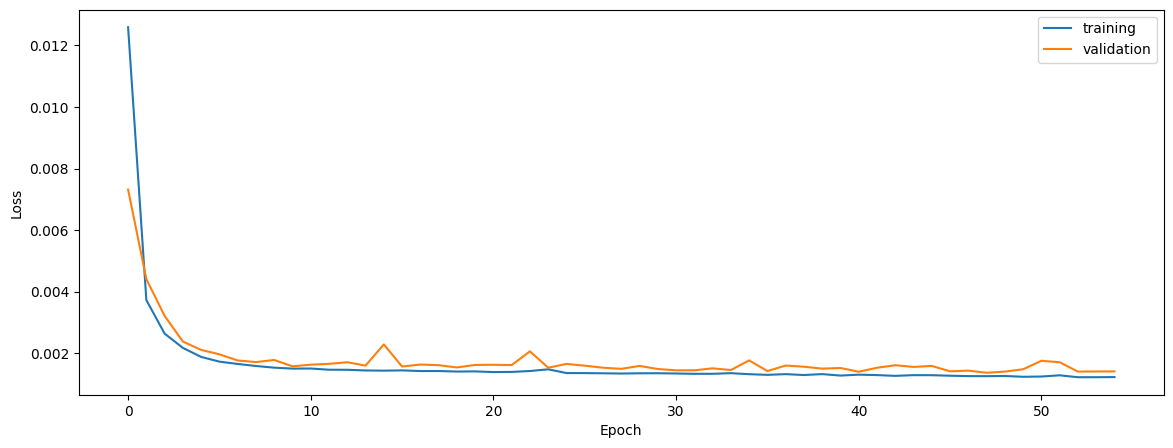

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9505080682182031
0.9595110375498996
0.9474048856377596


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9505080682182031
0.9595110375498996
0.9474048856377596


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9564073582695513
0.9621183397714422
0.9587670676445917


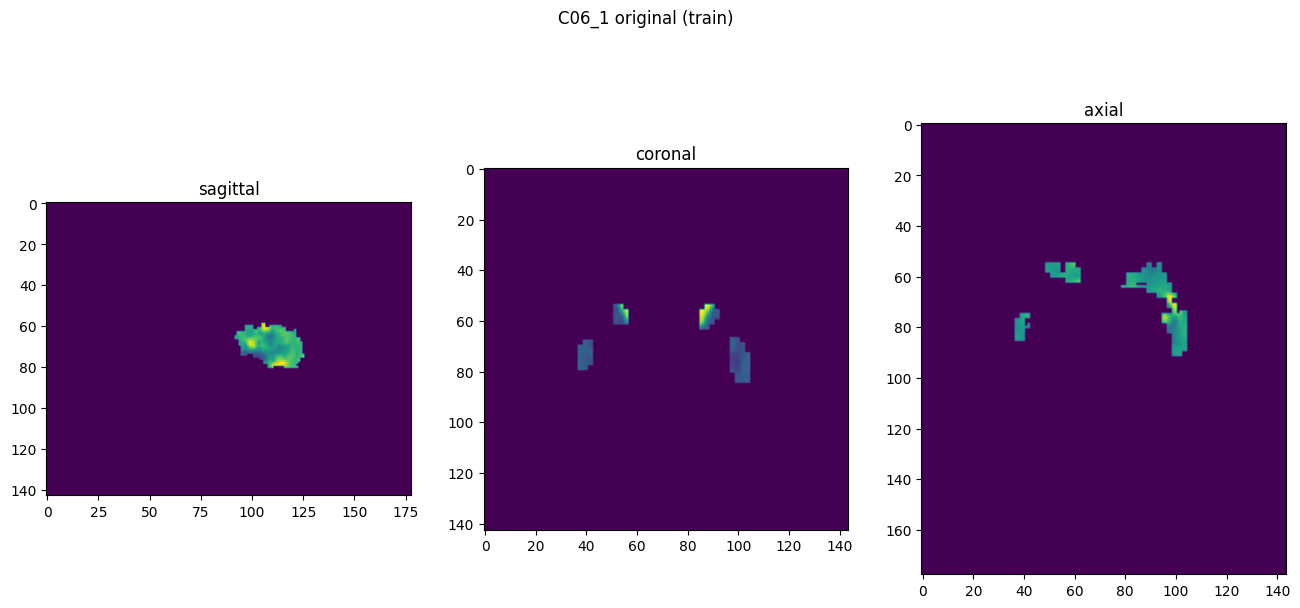

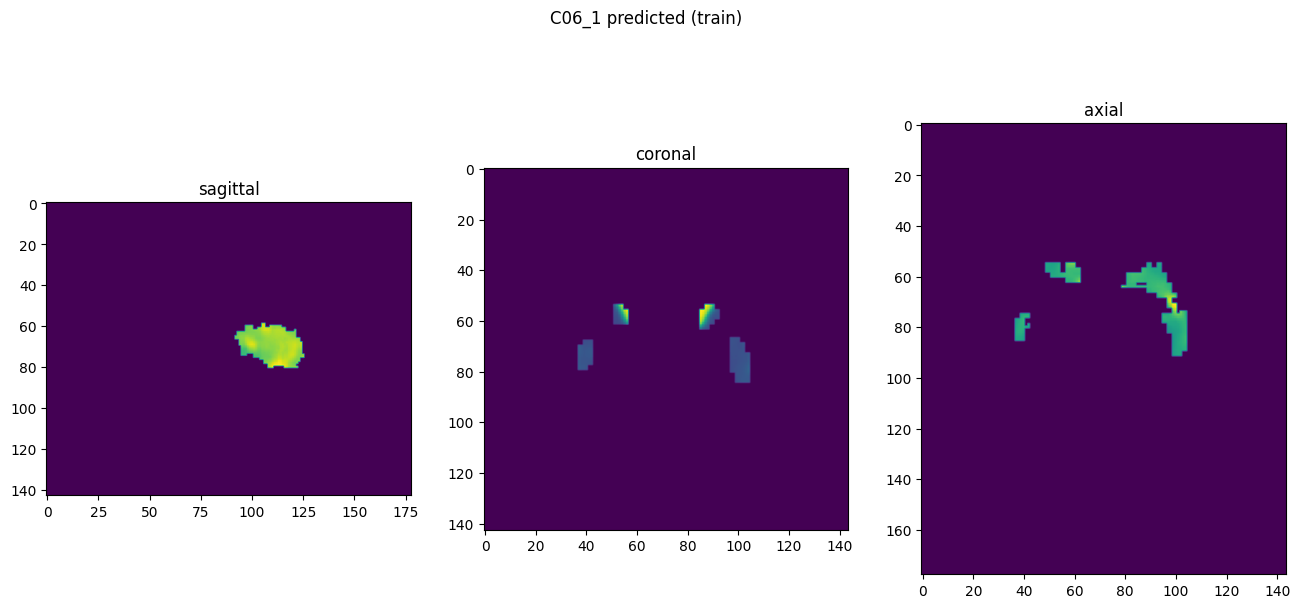

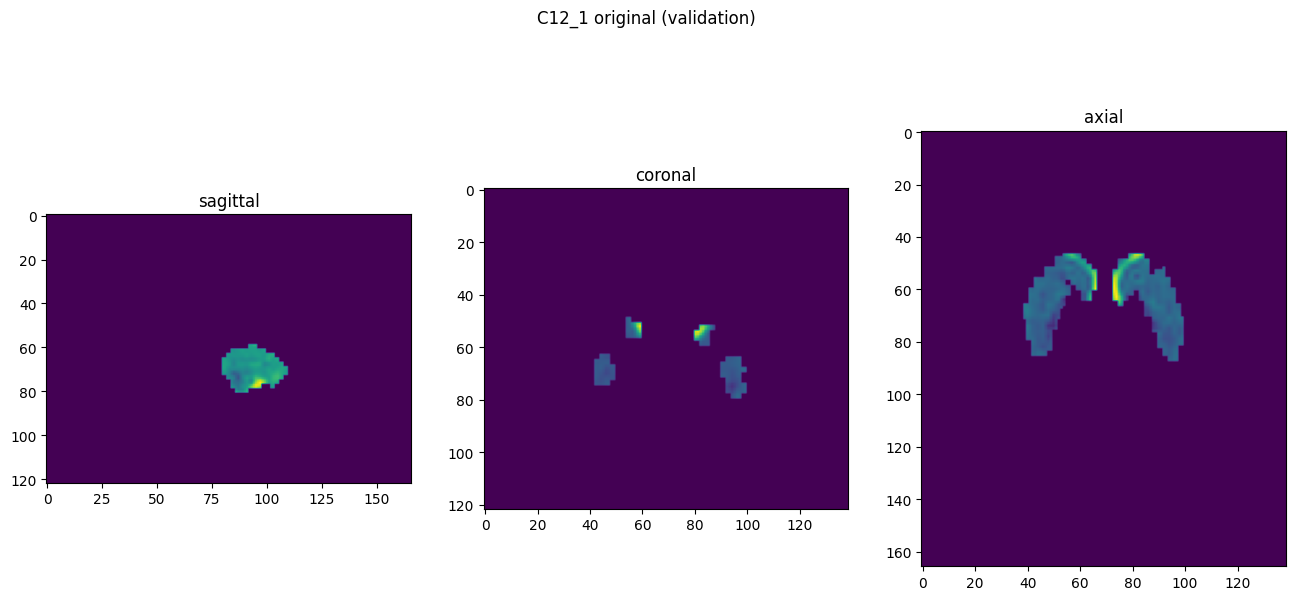

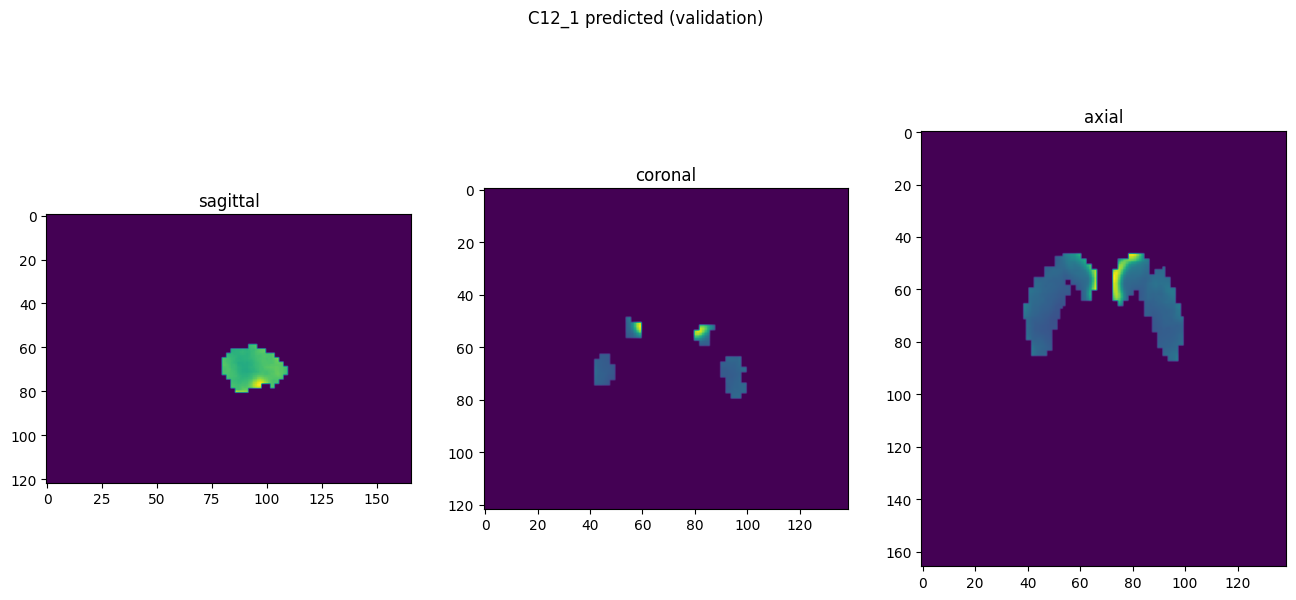

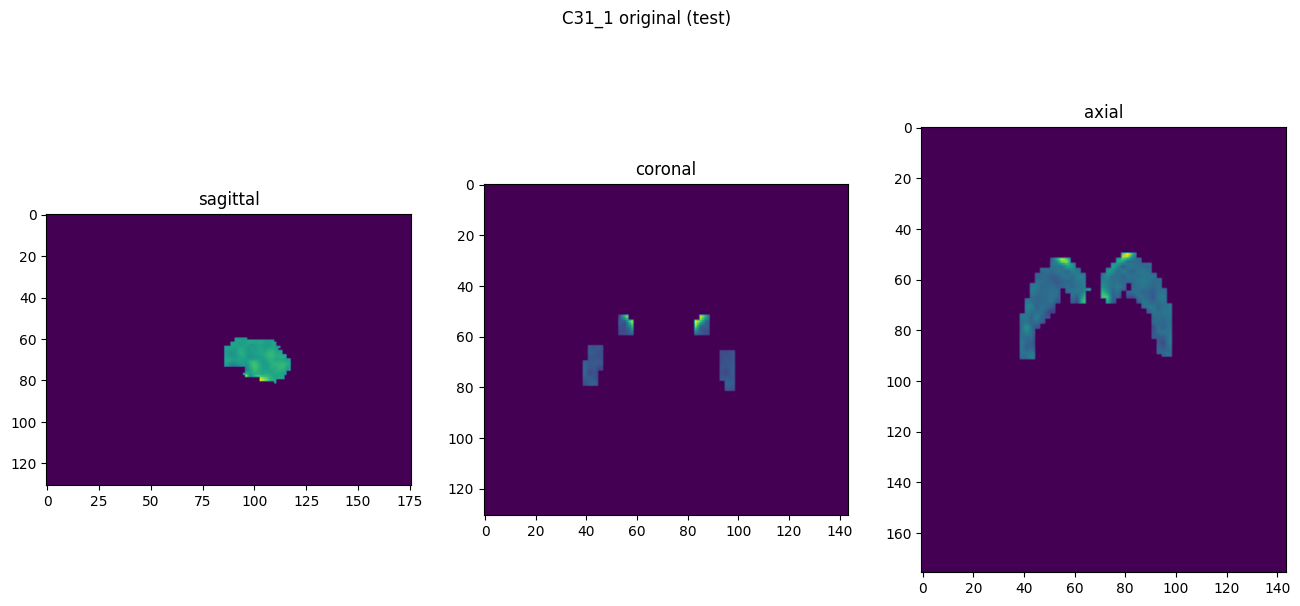

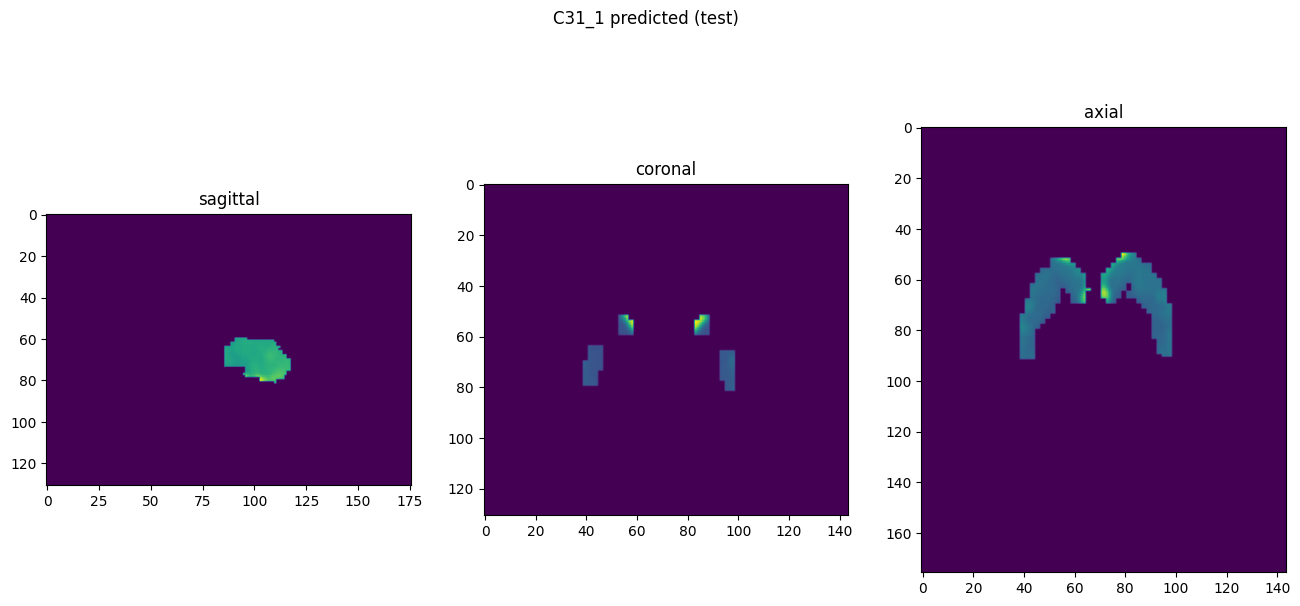

In [10]:
showResults(model, gen, threshold=None, background=False)